# Bag-of-words document classification

* BoW is the simplest way to do classification: Feature vector goes in, decision falls out.

* Feature vector: a vector with as many dimensions as we have unique features, and a non-zero value set for every feature present in our example
* Binary features: 1/0

In the following we work with the IMDB data, have a look on [how to read it in](read_imdb.ipynb). Here we just read the ready data in.

# IMDB data

* Familiar data
* Input vectorized as before
* But now we will also have to turn class labels into integers and back explicitly so we can use Keras


In [1]:
import json
import random
with open("intro-to-nlp/imdb_train.json") as f:
    data=json.load(f)
random.shuffle(data) #play it safe!

texts=[one_example["text"] for one_example in data]
labels=[one_example["class"] for one_example in data]


In [2]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer=CountVectorizer(max_features=100000,binary=True,ngram_range=(1,1))
feature_matrix=vectorizer.fit_transform(texts)
print("shape=",feature_matrix.shape)


shape= (25000, 74849)


Now we have the feature matrix done! Next thing we need is the class labels:

In [3]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

label_encoder=LabelEncoder() #Turns class labels into integers
class_numbers=label_encoder.fit_transform(labels)
print("class_numbers shape=",class_numbers.shape)
print("class labels",label_encoder.classes_) #this will let us translate back from indices to labels

class_numbers shape= (25000,)
class labels ['neg' 'pos']


* The data is ready :)

We need to build the network now
* Input
* Hidden Dense layer with some kind of non-linearity, and a suitable number of nodes
* Output Dense layer with the softmax activation (normalizes output to distribution) and as many nodes as there are classes

In [5]:
from keras.models import Model
from keras.layers import Input, Dense

example_count,feature_count=feature_matrix.shape #how many examples and features we've got?
example_count2=class_numbers.shape[0]
assert example_count==example_count2 #sanity check
class_count=len(label_encoder.classes_) #How many classes we've got?

#Build the network:
inp=Input(shape=(feature_count,)) #Input layer
hidden=Dense(200,activation="tanh")(inp) #Hidden layer
outp=Dense(class_count,activation="softmax")(hidden) #Output layer
model=Model(inputs=[inp], outputs=[outp])

...it's **this** simple...!

Once the model is constructed it needs to be compiled, for that we need to know:
* which optimizer we want to use (sgd is fine to begin with)
* what is the loss (sparse_categorial_crossentropy for multiclass of the kind we have is the right choice)
* which metrics to measure, accuracy is an okay choice

In [6]:
model.compile(optimizer="sgd",loss="sparse_categorical_crossentropy",metrics=['accuracy'])

A compiled model can be fitted on data:

In [7]:
hist=model.fit(feature_matrix,class_numbers,batch_size=100,verbose=1,epochs=10,validation_split=0.1)


Train on 22500 samples, validate on 2500 samples
Epoch 1/10
22500/22500 [==============================] - 34s 1ms/step - loss: 0.5665 - accuracy: 0.7726 - val_loss: 0.4829 - val_accuracy: 0.8252
Epoch 2/10
22500/22500 [==============================] - 33s 1ms/step - loss: 0.4366 - accuracy: 0.8379 - val_loss: 0.4070 - val_accuracy: 0.8444
Epoch 3/10
22500/22500 [==============================] - 34s 1ms/step - loss: 0.3786 - accuracy: 0.8549 - val_loss: 0.3678 - val_accuracy: 0.8548
Epoch 4/10
22500/22500 [==============================] - 33s 1ms/step - loss: 0.3441 - accuracy: 0.8665 - val_loss: 0.3447 - val_accuracy: 0.8640
Epoch 5/10
22500/22500 [==============================] - 34s 1ms/step - loss: 0.3202 - accuracy: 0.8746 - val_loss: 0.3275 - val_accuracy: 0.8668
Epoch 6/10
22500/22500 [==============================] - 35s 2ms/step - loss: 0.3014 - accuracy: 0.8820 - val_loss: 0.3158 - val_accuracy: 0.8720
Epoch 7/10
22500/22500 [==============================] - 35s 2ms/st

In [ ]:
print(hist.history["val_acc"])

* We ran for 10 epochs of training
* Made it to a decent accuracy on the validation data

* But we do not have the model saved, so let's fix that and get the whole thing done
* What constitutes a model (ie what we need to run the model on new data)
  - The feature dictionary in the vectorizer
  - The list of classes in their correct order
  - The structure of the network
  - The weights the network learned

* Do all these things, and run again. This time we also increase the number of epochs, see what happens.

In [12]:
from keras.models import Model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import optimizers
import os
import pickle

def save_model(file_name,model,label_encoder,vectorizer):
    """Saves model structure and vocabularies"""
    model_json = model.to_json()
    with open(file_name+".model.json", "w") as f:
        print(model_json,file=f)
    with open(file_name+".encoders.pickle","wb") as f:
        pickle.dump((label_encoder,vectorizer),f)
    #with open(file_name+".vocabularies.json","w") as f:
    #    classes=list(label_encoder.classes_)
    #    vocab=dict(((str(w),int(idx)) for w,idx in vectorizer.vocabulary_.items())) #must turn numpy objects to python ones
    #    json.dump((classes,vocab),f,indent=2)
        
example_count,feature_count=feature_matrix.shape #how many examples and features we've got?
example_count2=class_numbers.shape[0]
assert example_count==example_count2 #sanity check
class_count=len(label_encoder.classes_) #How many classes we've got?

#Build the network:
inp=Input(shape=(feature_count,)) #Input layer
hidden=Dense(200,activation="tanh")(inp) #Hidden layer
outp=Dense(class_count,activation="softmax")(hidden) #Output layer
model=Model(inputs=[inp], outputs=[outp])

# Let's try a different optimizer!
opt=optimizers.Adam()
model.compile(optimizer=opt,loss="sparse_categorical_crossentropy",metrics=['accuracy'])

# Save model and vocabularies, can be done before training
os.makedirs("models",exist_ok=True)
save_model("models/imdb_bow",model,label_encoder,vectorizer)
# Callback function to save weights during training, if validation loss goes down
save_cb=ModelCheckpoint(filepath="models/imdb_bow.weights.h5", monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
stop_cb=EarlyStopping(patience=2,verbose=1,restore_best_weights=True)
hist=model.fit(feature_matrix,class_numbers,batch_size=100,verbose=1,epochs=20,validation_split=0.1,callbacks=[save_cb,stop_cb])


Train on 22500 samples, validate on 2500 samples
Epoch 1/20
22500/22500 [==============================] - 60s 3ms/step - loss: 0.3195 - accuracy: 0.8659 - val_loss: 0.2778 - val_accuracy: 0.8824

Epoch 00001: val_loss improved from inf to 0.27781, saving model to models/imdb_bow.weights.h5
Epoch 2/20
22500/22500 [==============================] - 64s 3ms/step - loss: 0.0999 - accuracy: 0.9649 - val_loss: 0.3159 - val_accuracy: 0.8820

Epoch 00002: val_loss did not improve from 0.27781
Epoch 3/20
22500/22500 [==============================] - 64s 3ms/step - loss: 0.0383 - accuracy: 0.9876 - val_loss: 0.4562 - val_accuracy: 0.8824

Epoch 00003: val_loss did not improve from 0.27781
Restoring model weights from the end of the best epoch
Epoch 00003: early stopping


In [13]:
import numpy
from sklearn.metrics import classification_report, confusion_matrix

#Validation data used during training:
val_instances,val_labels,_=hist.validation_data

print("Network output=",model.predict(val_instances))
predictions=numpy.argmax(model.predict(val_instances),axis=1)
print("Maximum class for each example=",predictions)
gold=val_labels
conf_matrix=confusion_matrix(list(gold),list(predictions))
print("Confusion matrix=\n",conf_matrix)
### FIXED VERSION (thanks for reporting the bug during the lecture!)
### 
gold_labels=label_encoder.inverse_transform(list(gold))
predicted_labels=label_encoder.inverse_transform(list(predictions))
#print("Gold labels=",gold_labels)
#print("Predicted labels=",predicted_labels)
print(classification_report(gold_labels,predicted_labels))


Network output= [[0.37979558 0.6202045 ]
 [0.6799087  0.3200913 ]
 [0.5277653  0.4722348 ]
 ...
 [0.00333667 0.9966633 ]
 [0.36800465 0.6319953 ]
 [0.01387937 0.98612064]]
Maximum class for each example= [1 0 0 ... 1 1 1]
Confusion matrix=
 [[1138   94]
 [ 200 1068]]
              precision    recall  f1-score   support

         neg       0.85      0.92      0.89      1232
         pos       0.92      0.84      0.88      1268

    accuracy                           0.88      2500
   macro avg       0.88      0.88      0.88      2500
weighted avg       0.89      0.88      0.88      2500



/home/ginter/venv-teachin/lib/python3.6/site-packages/sklearn/preprocessing/_label.py:289: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# Learning progress

* The history object we get lets us inspect the accuracy during training
* Remarks:
  - Accuracy on training data keeps going up
  - Accuracy on validation (test) data flattens out after a but over 10 epochs, we are learning very little past that point
  - What we see is the network keeps overfitting on the training data to the end

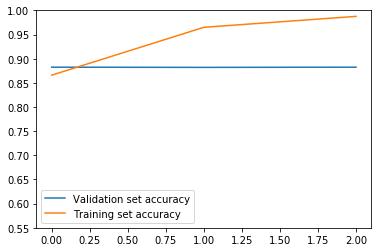

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.ylim(0.55,1.0)
plt.plot(hist.history["val_accuracy"],label="Validation set accuracy")
plt.plot(hist.history["accuracy"],label="Training set accuracy")
plt.legend()
plt.show()

# Summary

* We put together a program to train a neural network classifier for sentiment detector
* We learned the necessary code/techniques to save models, and feed the training with data in just the right format
* We observed the training across epochs
* We saw how the classifier can be applied to various text classification problems
* The IMDB sentiment classifier ended up at nearly 90% accuracy, the state of the art is about 95%, we got surprisingly far in few lines of code
